In [1]:
%load_ext autoreload
%autoreload 2

# Analysis of hyperparameter search
The purpose of this notebook is to understand which hyperparameters in training CT-RNNs on our ModularArithmeticTask lead to successfull and stable performance.

## Imports

In [2]:
import json
import os
import pandas as pd
import matplotlib.pyplot as plt

import jax.numpy as jnp
from jax import random
from flax import linen as nn
from modularRNN.model import CTRNNCell
from modularRNN.task import ModularArithmeticTask
from modularRNN.training import create_train_state, ModelParameters

from sklearn.decomposition import PCA

from functools import partial

2024-04-04 14:17:44.891624: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-04-04 14:17:45.645735: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-04-04 14:17:45.645794: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-04-04 14:17:45.645800: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed proper

## Identifying models of interest

In [3]:
job_folder = "../../data/hyperparameter"
search_results = []

for task_id in range(384):
    try:
        metrics_loc = os.path.join(job_folder, f"task_{task_id}/metrics_history.csv")
        metrics_min = pd.read_csv(metrics_loc)['test_loss'].min()
        
        params_loc = os.path.join(job_folder, f"task_{task_id}/params.json")
    
        with open(params_loc, 'r') as f:
            json_params = json.load(f)
        
        seed = json_params.get('seed', 0)
        alpha = json_params.get('alpha', 0.1)
        noise = json_params.get('noise', 0.05)
        pulse_mean = json_params.get('pulse_mean', 8)
        mod_set = json_params.get('mod_set', [5,])
        mod_value_list = len(mod_set)
        training_trials = json_params.get('training_trials', 3200)
        train_batch_size = json_params.get('train_batch_size', 128)
        testing_trials = json_params.get('testing_trials', 320)
        lr = json_params.get('lr', 0.001)
        epochs = json_params.get('epochs', 500)

        task_stats_params = {
            'test_min': metrics_min,
            'seed': seed,
            'noise': noise,
            'pulse_mean': pulse_mean,
            'mod_set': mod_set,
            'mod_value_list': mod_value_list,
            'training_trials': training_trials,
            'train_batch_size': train_batch_size,
            'testing_trials': testing_trials,
            'lr': lr,
            'epochs': epochs,
        }
        search_results.append(task_stats_params)

    except FileNotFoundError:
        continue

In [4]:
df_search_results = pd.DataFrame(search_results)
df_search_results.sort_values('test_min').head(15)

,test_min,seed,noise,pulse_mean,mod_set,mod_value_list,training_trials,train_batch_size,testing_trials,lr,epochs
227,0.000006,352,0.00,12,[2],1,3200,128,640,0.010,2500
105,0.000010,166,0.00,12,[5],1,6400,128,640,0.005,2500
148,0.000010,238,0.00,10,[4],1,6400,128,640,0.005,2000
185,0.000014,290,0.00,12,[5],1,9600,128,640,0.005,1000
56,0.000014,86,0.00,10,"[6, 3]",2,9600,128,640,0.010,2000
142,0.000017,229,0.00,11,"[7, 6, 2]",3,9600,128,640,0.005,2000
49,0.000022,76,0.00,11,[7],1,9600,128,640,0.010,2500
175,0.000023,275,0.00,12,"[2, 4]",2,6400,128,640,0.001,2000
128,0.000025,204,0.00,11,[5],1,6400,128,640,0.010,1500
15,0.000025,18,0.00,8,[8],1,3200,128,640,0.010,2500


## Understand model performance

In [5]:
task_id = 'task_250'

params_for_json = f"../../data/hyperparameter/{task_id}/params.json"
example_csv = f"../../data/hyperparameter/{task_id}/metrics_history.csv"
model_params_save = f"../../data/hyperparameter/{task_id}/test_params.bin"

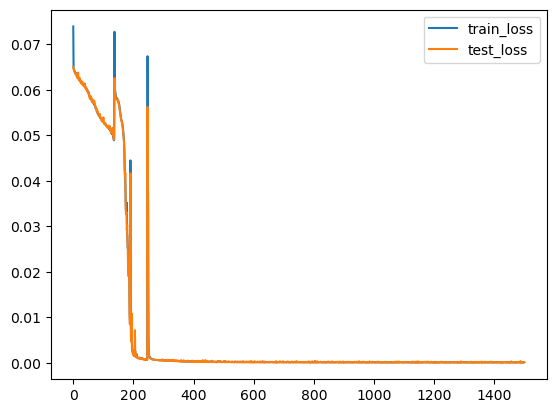

In [6]:
df_metrics = pd.read_csv(example_csv)

plt.plot(df_metrics['train_loss'], label='train_loss')
plt.plot(df_metrics['test_loss'], label='test_loss')
plt.legend()
plt.show()

In [7]:
with open(params_for_json, 'r') as f:
    json_params = json.load(f)

seed = json_params.get('seed', 0)
alpha = json_params.get('alpha', 0.1)
noise = json_params.get('noise', 0.05)
pulse_mean = json_params.get('pulse_mean', 8)
mod_set = json_params.get('mod_set', [5,])
training_trials = json_params.get('training_trials', 3200)
train_batch_size = json_params.get('train_batch_size', 128)
testing_trials = json_params.get('testing_trials', 320)
lr = json_params.get('lr', 0.001)
epochs = json_params.get('epochs', 500)

key = random.PRNGKey(seed)

In [8]:
mod_set = jnp.array(mod_set)
pulse_distribution = partial(random.poisson, lam=pulse_mean)

key, subkey = random.split(key)
modtask = ModularArithmeticTask(subkey, training_trials, testing_trials, train_batch_size, mod_set, pulse_distribution,)
training_dataset, testing_dataset = modtask.tf_datasets()

100%|██████████| 6400/6400 [06:25<00:00, 16.62it/s]  
2024-04-04 14:24:48.795150: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-04-04 14:24:48.795173: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
100%|██████████| 640/640 [00:32<00:00, 19.99it/s]


In [9]:
features = 100
alpha = jnp.float32(alpha)
noise = jnp.float32(0.00)

ctrnn = nn.RNN(CTRNNCell(features=features, alpha=alpha, noise=noise, out_shape=10,))

key, subkey = random.split(key)
state = create_train_state(ctrnn, subkey, lr,)

In [10]:
model_params = ModelParameters(state)
model_params.deserialize(model_params_save,)

In [11]:
for _inputs, _outputs in testing_dataset.as_numpy_iterator():
    pass
    
key, subkey = random.split(key)
z_0, rates_0 = ctrnn.apply(model_params.params, _inputs, init_key=subkey,)

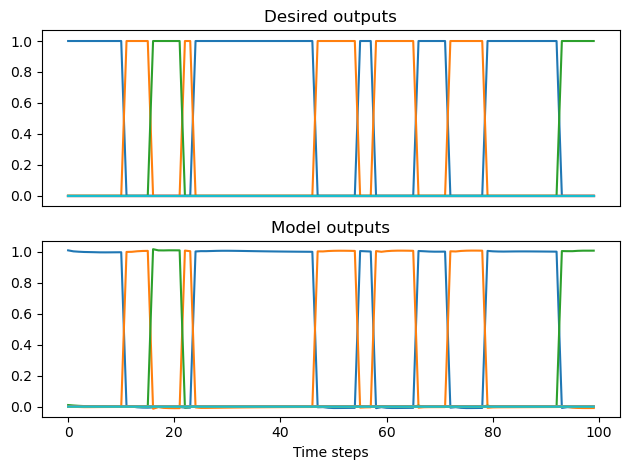

In [12]:
fig, axs = plt.subplots(2, 1, sharey=True)

axs[0].plot(_outputs[0,:,:])
axs[0].set_title('Desired outputs')
axs[0].set_xticks([])
axs[1].plot(z_0[0,:,:])
axs[1].set_title('Model outputs')
axs[1].set_xlabel('Time steps')
plt.tight_layout()
plt.show()

In [13]:
rates_list = []

for _inputs, _outputs in training_dataset.as_numpy_iterator():
    key, subkey = random.split(key)
    _, _rates = ctrnn.apply(model_params.params, _inputs, init_key=subkey,)
    rates_list.append(_rates)

In [14]:
rates_ = jnp.concatenate(rates_list, axis=0)
rates_.shape

(6400, 100, 100)

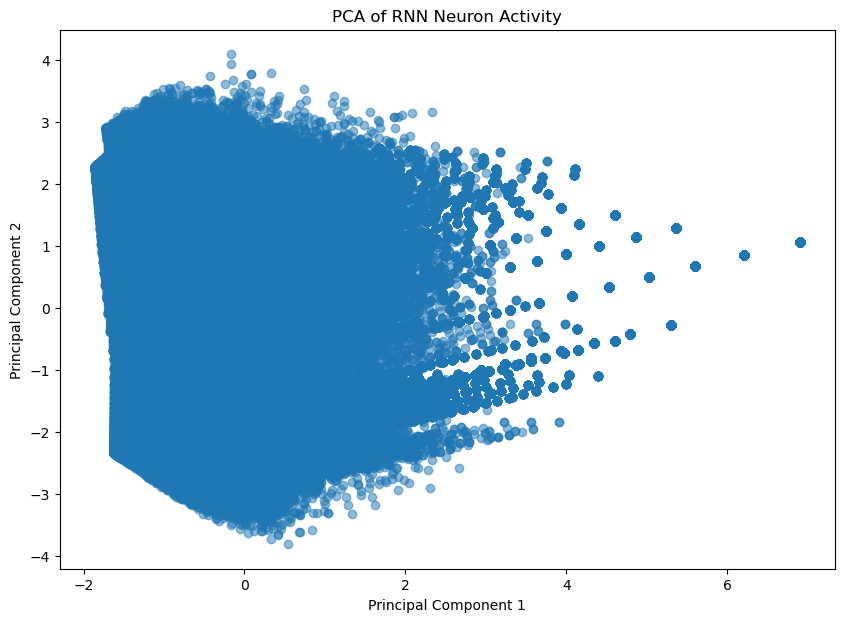

In [15]:
rates_reshaped = rates_.reshape(-1, rates_.shape[-1])

pca = PCA(n_components=2)
principal_components = pca.fit_transform(rates_reshaped)

plt.figure(figsize=(10, 7))
plt.scatter(principal_components[:, 0], principal_components[:, 1], alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of RNN Neuron Activity')
plt.show()

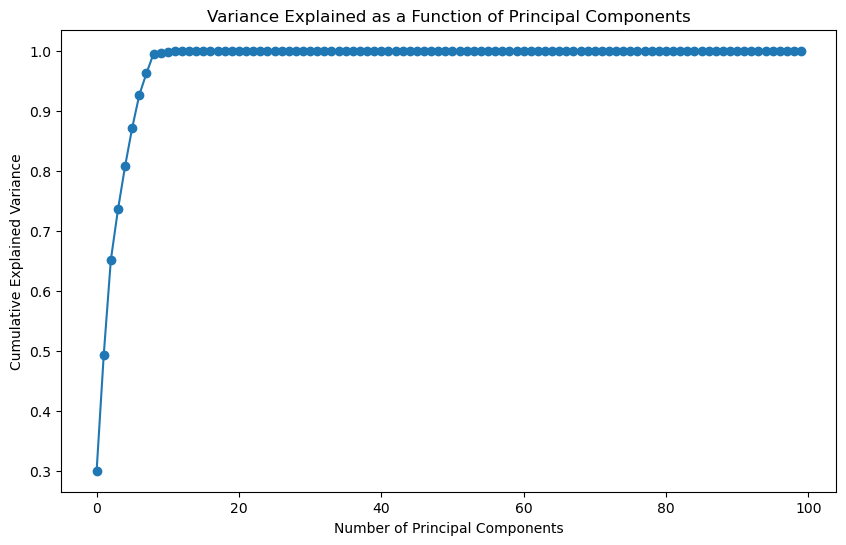

In [16]:
pca_full = PCA()
pca_full.fit(rates_reshaped)

cumulative_variance = jnp.cumsum(pca_full.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Variance Explained as a Function of Principal Components')
plt.show()

In [17]:
cumulative_variance

Array([0.30016232, 0.49334052, 0.6517246 , 0.7354578 , 0.80765295,
       0.8716493 , 0.92641795, 0.9624337 , 0.99498487, 0.99667835,
       0.99797183, 0.99883115, 0.9993326 , 0.99949056, 0.9996222 ,
       0.9997113 , 0.999768  , 0.9998157 , 0.9998585 , 0.99988425,
       0.9999086 , 0.9999272 , 0.9999408 , 0.99995285, 0.999964  ,
       0.9999718 , 0.9999779 , 0.9999836 , 0.9999879 , 0.99999124,
       0.99999416, 0.9999965 , 0.9999983 , 0.9999993 , 0.99999994,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

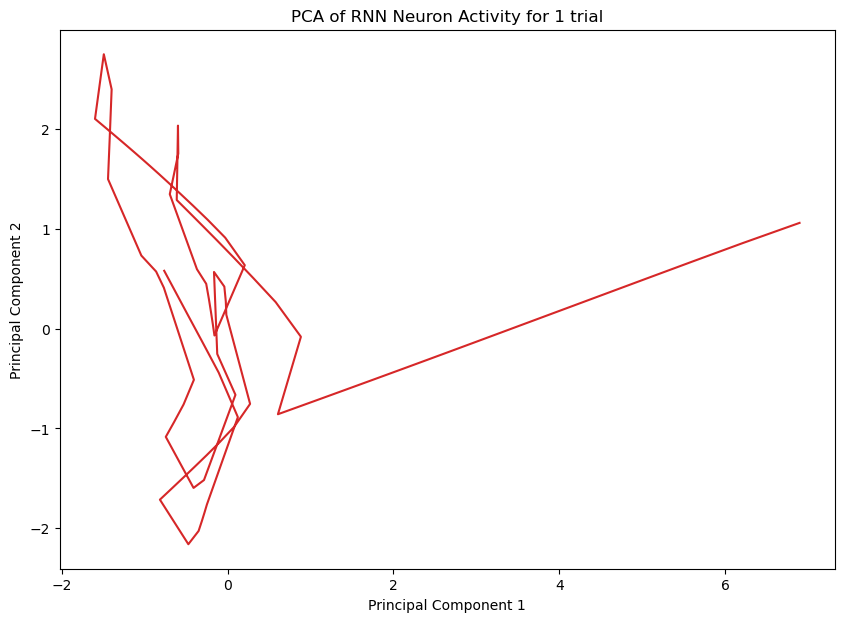

In [18]:
reshaped_pc = principal_components.reshape(6400, 100, 2)

plt.figure(figsize=(10, 7))
plt.plot(reshaped_pc[0, :, 0], reshaped_pc[0, :, 1], color='tab:red')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of RNN Neuron Activity for 1 trial')
plt.show()